In [49]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [50]:
df_gld = pd.read_csv(r"D:\study\tieu_luan_chuyen_nganh\demo\timeseries_hybrid\data\goldprice\gld_price_data.csv")
df_gld['Date'] = pd.to_datetime(df_gld['Date'])  # Đảm bảo cột 'Date' là kiểu thời gian

In [51]:
data = df_gld[['GLD']].values
time = df_gld['Date'].values

In [52]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [53]:
# Định nghĩa hàm tạo các cửa sổ trượt
def create_sliding_windows(data, window_size):
    X, y = [], [] #khởi tạo tập rỗng
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [54]:
window_size = 5
X, y = create_sliding_windows(scaled_data, window_size)
X = np.reshape(X, (2285,5))


In [55]:
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [56]:
def find_optimal_k(X_train, y_train, max_k=30):
    k_range = range(1, max_k+1)
    k_rmse_scores = []
    
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k, metric='manhattan')
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        rmse_scores = -cross_val_score(knn, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
        k_rmse_scores.append(rmse_scores.mean())
    
    # Vẽ biểu đồ RMSE theo giá trị k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, k_rmse_scores, marker='o')
    plt.xlabel('Giá trị k')
    plt.ylabel('RMSE')
    plt.title('RMSE theo các giá trị k')
    plt.show()
    
    # Tìm giá trị k có RMSE nhỏ nhất
    optimal_k = k_range[np.argmin(k_rmse_scores)]
    print(f'Giá trị k tối ưu: {optimal_k}')
    return optimal_k


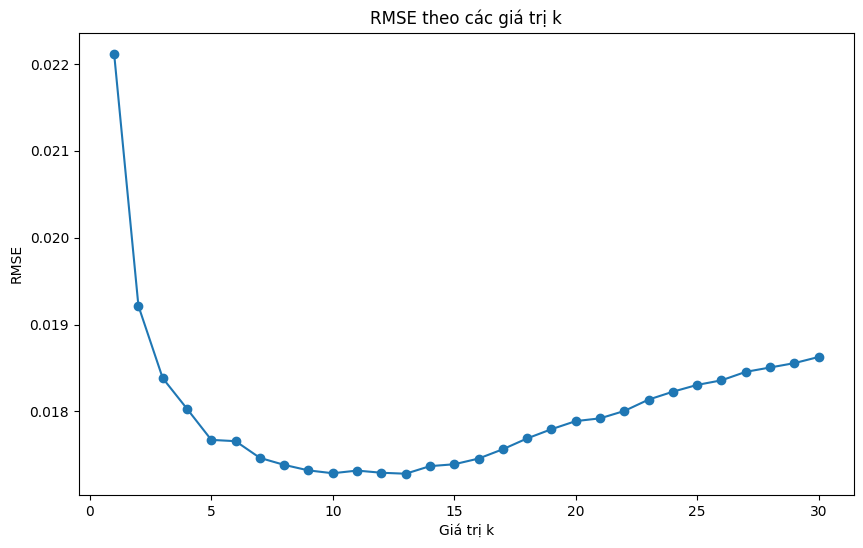

Giá trị k tối ưu: 13


In [57]:
optimal_k = find_optimal_k(X_train, y_train)

In [70]:
def dtw_distance(ts_a, ts_b):
    # Chuyển chuỗi thời gian thành vector 1-D (nếu chưa phải)
    ts_a = np.array(ts_a).flatten()  # Chuyển về vector 1 chiều
    ts_b = np.array(ts_b).flatten()  # Chuyển về vector 1 chiều
    distance, path = fastdtw(ts_a, ts_b, dist=euclidean)
    return distance

def knn_dtw(X_train, y_train, X_test_instance, k=3):
    distances = []
    
    # Đảm bảo rằng X_test_instance là vector 1-D
    X_test_instance = np.array(X_test_instance).flatten()

    # Tính khoảng cách DTW giữa X_test_instance và từng chuỗi trong X_train
    for i in range(len(X_train)):
        # Đảm bảo rằng từng chuỗi trong X_train là vector 1-D
        X_train_instance = np.array(X_train[i]).flatten()
        
        # Tính khoảng cách DTW
        dist = dtw_distance(X_test_instance, X_train_instance)
        distances.append((dist, y_train[i]))
    
    # Sắp xếp các hàng xóm gần nhất dựa trên khoảng cách DTW
    distances.sort(key=lambda x: x[0])
    
    # Lấy k hàng xóm gần nhất
    neighbors = [distances[i][1] for i in range(k)]
    
    # Dự đoán bằng cách lấy trung bình các nhãn của k hàng xóm gần nhất
    return np.mean(neighbors)


In [65]:
knn = KNeighborsRegressor(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=13)

In [79]:
y_pred = knn.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)


In [80]:
acctually_prices = data[split_idx+window_size:]
acctually_prices = np.reshape(acctually_prices, -1)

In [81]:
# Tính Mean Squared Error
mse = mean_squared_error(acctually_prices, y_pred)
print(f"MSE: {mse}")

# Tính MAE
mae = mean_absolute_error(acctually_prices, y_pred)
print(f"MAE: {mae}")

#Tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
mape = calculate_mape(acctually_prices, y_pred)
print(f"MAPE: {mape}")


MSE: 1.2890696783000812
MAE: 0.8465528550749031
MAPE: 4.458802898563659


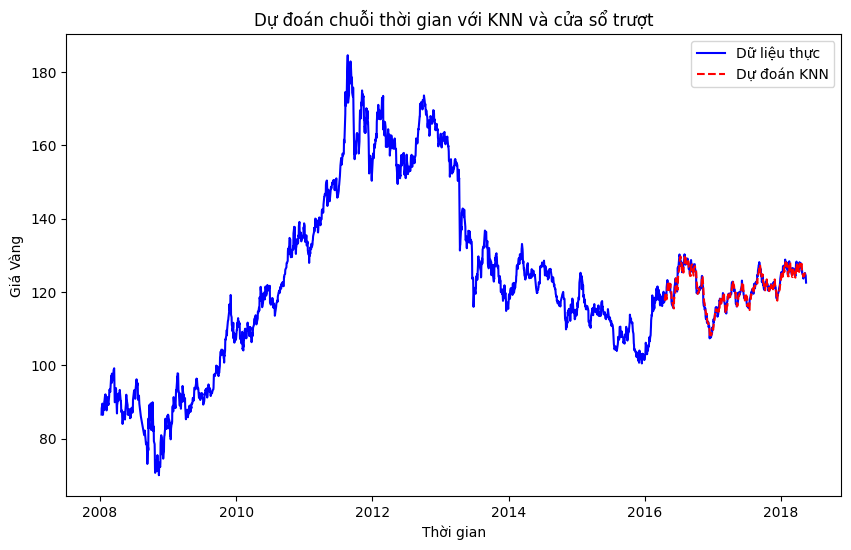

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(time[window_size:], data[window_size:], label='Dữ liệu thực', color='blue')
plt.plot(time[split_idx+window_size:], y_pred, label='Dự đoán KNN', color='red', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Giá Vàng')
plt.legend()
plt.show()